In [40]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cpu



#### Loading Datas

In [42]:
spacy_eng = spacy.load("en")

In [43]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [44]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir

        self.df = pd.read_csv(captions_file, error_bad_lines=False, names=['image', 'caption'], header=None, sep='\t', nrows=1000)
        self.transform = transform
        # Get img, caption columns
        self.df["image"] = self.df["image"].apply(lambda x: self.removeNumbers(x))
        self.imgs = self.df["image"]

        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def removeNumbers(self, image):
          image = image.split('#')[0]
          check = image.split('.')
          if len(check)>2:
            image = check[0]+"."+check[1]
          return image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [45]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [46]:
def get_loader(
    root_folder,annotation_file,transform,batch_size=32,
    num_workers=8,shuffle=True,pin_memory=True,train_test_ratio=0.0):
  
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    dataset_train, dataset_test = torch.utils.data.random_split(dataset, 
                                  [int(len(dataset)*train_test_ratio), len(dataset)-int(len(dataset)*train_test_ratio)],
                                  generator=torch.Generator().manual_seed(42))

    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    ) 

    return train_loader, dataset_train, test_loader, dataset_test, dataset

#### implementing Networks

In [47]:
class BahdanauAttention(nn.Module):

    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, decoder_hidden):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
        
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(DecoderRNN, self).__init__()
        self.num_features = num_features
        self.embedding_dim = embed_size
        self.hidden_dim = hidden_size
        self.vocab_size = vocab_size
        self.sample_temp = 0.5

        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + num_features, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention = BahdanauAttention(num_features, hidden_size)
        self.drop = nn.Dropout(0.5)
        self.init_h = nn.Linear(num_features, hidden_size)
        self.init_c = nn.Linear(num_features, hidden_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions, sample_prob = 0.0):
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = embed.size(1)
        feature_size = features.size(1)
        batch_size = embed.size(0)
        
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)
        word_embed = embed[:,0,:]
        for t in range(seq_len):

            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight

            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring.topk(1)[1]
            word_embed = self.embeddings(top_idx).squeeze(1)
            # print(top_idx.shape)
            
        return outputs, atten_weights


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0
    def greedy_search(self, features, vocabulary, max_sentence = 40):

        sentence = []
        weights = []
        input_word = torch.tensor([vocabulary.stoi['<SOS>']]).to(device)
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = torch.tensor(top_idx)
            if (len(sentence) >= max_sentence or top_idx == vocabulary.stoi['<EOS>']):
                break
        return sentence, weights


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, num_features)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs, _ = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=40):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image)
            sentence, weights = self.decoderRNN.greedy_search(x, vocabulary, max_sentence = max_length)

        return [vocabulary.itos[idx] for idx in sentence], weights


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0



#### Training

In [48]:
model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Second_model.pth.tar"


def save_checkpoint(state, filename=model_save_dir):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = True
save_model = True
train_CNN = False


# Hyperparameters
batch_size = 64
embed_size = 256
hidden_size = 256
num_features = 2048
num_layers = 1
learning_rate = 3e-4
momentum = 0.9
num_epochs = 100



transform = transforms.Compose([ 
    transforms.Resize((224, 224)),                          
    # transforms.RandomCrop(224),                     
    # transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

train_loader, dataset_train, test_loader, dataset_test, dataset = get_loader(
    root_folder="/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flicker8k_Dataset",
    annotation_file="/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flickr8k.token.txt",
    transform=transform,
    num_workers=2,
    batch_size=batch_size,
    train_test_ratio=0.95
)
vocab_size = len(dataset.vocab)


# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, num_features).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [49]:
def write_log(file_path, stat):
  with open(file_path, 'a') as the_file:
    the_file.write(stat+"\n")

In [50]:
def plot_examples(imgs):

  print("\n")
  img2plot = imgs[0].cpu().permute(1,2,0)-torch.min(imgs[0].cpu().permute(1,2,0))
  img2plot = img2plot/torch.max(img2plot)
  # plt.imshow(img2plot)
  # plt.show()
  with torch.no_grad():
    predicted_caption, weights = model.caption_image(imgs[0].unsqueeze(0), dataset.vocab)
  visualize_attention(img2plot, predicted_caption, weights)
  # print("\n"+" ".join(predicted_caption))
  # print("\n")


def visualize_attention(orig_image, words, atten_weights):
    fig = plt.figure(figsize=(20,15)) 
    len_tokens = len(words)
    
    for i in range(len(words)):
        atten_current = atten_weights[i].detach().numpy()
        atten_current = atten_current.reshape(7,7)       
        ax = fig.add_subplot(len_tokens//2, len_tokens//2, i+1)
        ax.set_title(words[i])
        img = ax.imshow(np.squeeze(orig_image))
        ax.imshow(atten_current, cmap='gray', alpha=0.8, extent=img.get_extent(), interpolation = 'bicubic')
    plt.tight_layout()
    plt.show()

In [51]:
def validation():
  
  Loss = 0
  Acc = 0
  with torch.no_grad():
    for idx, (imgs, captions) in enumerate(test_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        captions = captions.permute(1,0)
        
        outputs = model(imgs, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
        acc = torch.sum(outputs.topk(1)[1].reshape(-1) == captions.reshape(-1))/ captions.reshape(-1).shape[0]
        Acc = Acc+acc
        Loss = Loss+loss.item()

  Acc = Acc/(idx+1)
  Loss = Loss/(idx+1)
  return Loss, Acc

In [52]:
def train(print_every):

    if load_model:
      load_checkpoint(torch.load(model_save_dir), model, optimizer)
    
    for epoch in range(num_epochs):

        step = 0

        if save_model:
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "step": step,}
          save_checkpoint(checkpoint)
        num_itters = len(train_loader)
        for idx, (imgs, captions) in enumerate(train_loader):

            imgs = imgs.to(device)
            captions = captions.to(device)
            captions = captions.permute(1,0)
            
            outputs = model(imgs, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
            acc = torch.sum(outputs.topk(1)[1].reshape(-1) == captions.reshape(-1))/ captions.reshape(-1).shape[0]
            
            if step % print_every == 0:
              loss_val, acc_val = validation()
              stats = '{2}/{3} - {0}/{1} |  Loss train-val = {4:.4f} - {6:.4f} | Acc train - val = {5:.4f} - {7:.4f}'.format(
                    idx, num_itters, epoch, num_epochs, loss.item(), acc, loss_val, acc_val)
              print('\r' + stats)
              write_log("/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Logs2.txt", stats)

            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            
        plot_examples(imgs)


=> Loading checkpoint
=> Saving checkpoint
0/100 - 0/15 |  Loss train-val = 3.5495 - 3.5802 | Acc train - val = 0.1051 - 0.1530
0/100 - 5/15 |  Loss train-val = 3.5526 - 3.5357 | Acc train - val = 0.1382 - 0.1609
0/100 - 10/15 |  Loss train-val = 3.5531 - 3.5775 | Acc train - val = 0.1322 - 0.1478




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


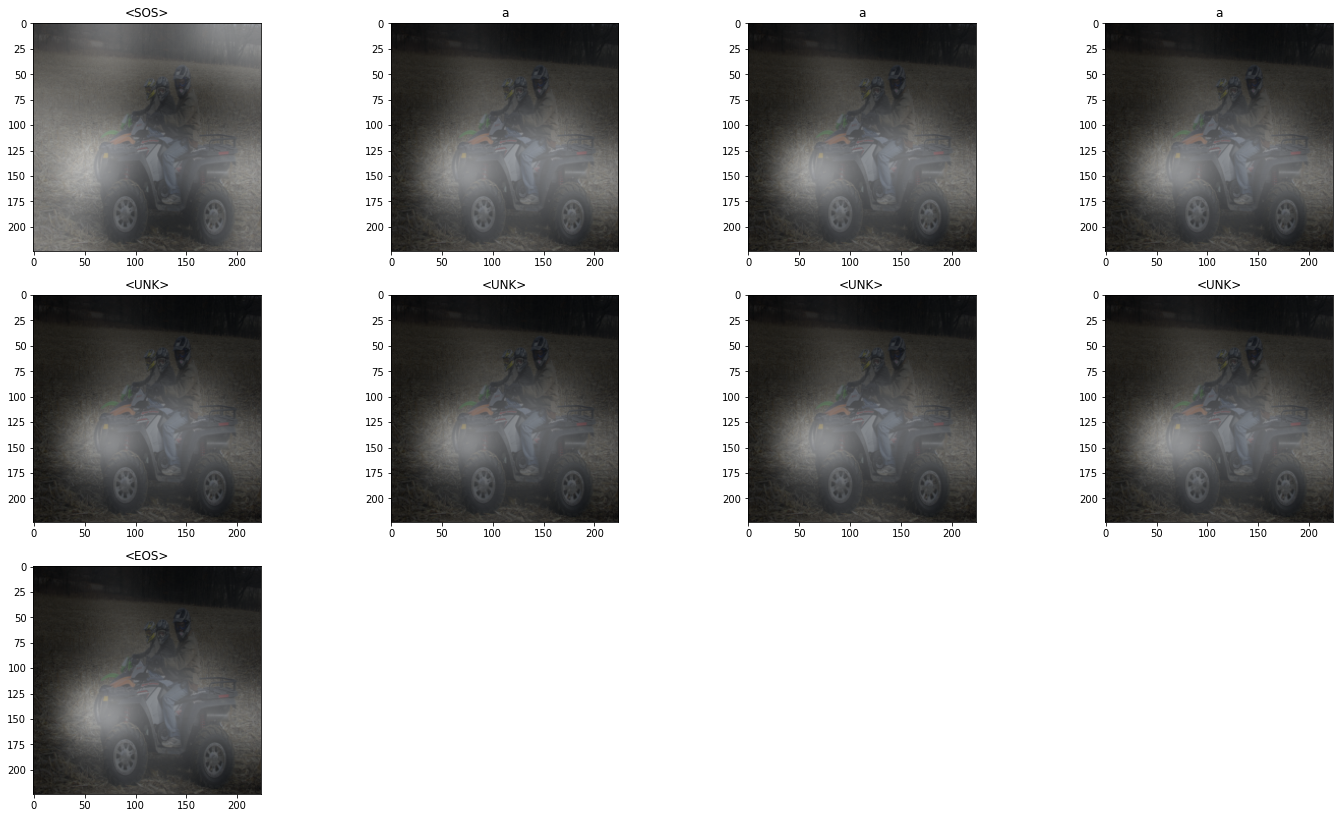

=> Saving checkpoint
1/100 - 0/15 |  Loss train-val = 3.4821 - 3.5341 | Acc train - val = 0.1591 - 0.1513
1/100 - 5/15 |  Loss train-val = 3.6020 - 3.5545 | Acc train - val = 0.1363 - 0.1513
1/100 - 10/15 |  Loss train-val = 3.5756 - 3.5411 | Acc train - val = 0.1187 - 0.1504




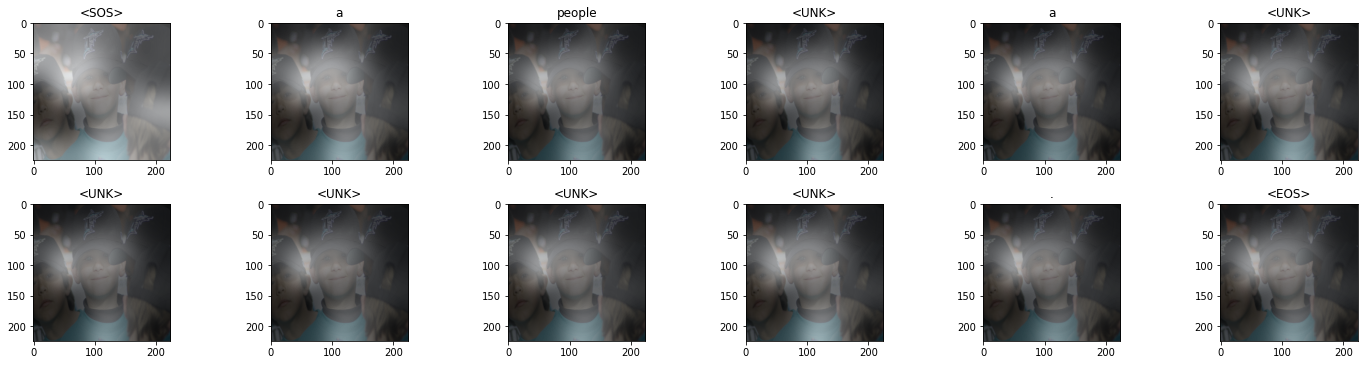

=> Saving checkpoint
2/100 - 0/15 |  Loss train-val = 3.5056 - 3.5196 | Acc train - val = 0.1296 - 0.1600
2/100 - 5/15 |  Loss train-val = 3.4120 - 3.5140 | Acc train - val = 0.1595 - 0.1557
2/100 - 10/15 |  Loss train-val = 3.4571 - 3.5208 | Acc train - val = 0.1444 - 0.1504


In [ ]:
train(5)